In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)

from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, TensorBoard

In [2]:
CSV_PATH = os.path.join(os.getcwd(), "datasets", "cases_malaysia_train.csv")
df = pd.read_csv(CSV_PATH)

        date cases_new  cases_import  cases_recovered  cases_active  \
0  25/1/2020         4             4                0             4   
1  26/1/2020         0             0                0             4   
2  27/1/2020         0             0                0             4   

   cases_cluster  cases_unvax  cases_pvax  cases_fvax  cases_boost  ...  \
0              0            4           0           0            0  ...   
1              0            0           0           0            0  ...   
2              0            0           0           0            0  ...   

   cases_60_69  cases_70_79  cases_80  cluster_import  cluster_religious  \
0            0            0         0             NaN                NaN   
1            0            0         0             NaN                NaN   
2            0            0         0             NaN                NaN   

   cluster_community  cluster_highRisk  cluster_education  \
0                NaN               NaN          

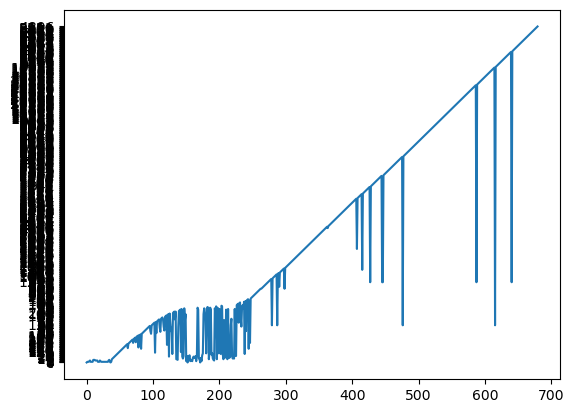

In [3]:
print(df.head(3))
print(df.info())
print(df.shape)

plt.figure()
plt.plot(df["cases_new"])
plt.show()

In [4]:
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")
# Make sure to order by ascending date
df = df.sort_values("date")

print(df.head(20))

         date cases_new  cases_import  cases_recovered  cases_active  \
0  2020-01-25         4             4                0             4   
1  2020-01-26         0             0                0             4   
2  2020-01-27         0             0                0             4   
3  2020-01-28         0             0                0             4   
4  2020-01-29         3             3                0             7   
5  2020-01-30         1             1                0             8   
6  2020-01-31         0             0                0             8   
7  2020-02-01         0             0                0             8   
8  2020-02-02         0             0                0             8   
9  2020-02-03         0             0                0             8   
10 2020-02-04         2             2                0            10   
11 2020-02-05         2             2                1            11   
12 2020-02-06         2             1                0          

In [5]:
# Convert cases_new to numeric data type
df["cases_new"] = pd.to_numeric(df["cases_new"], errors="coerce")

# Interpolation to Handle missing values
df["cases_new"] = df["cases_new"].interpolate(method="polynomial", order=2)

print(df.info())
print(df.tail(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 0 to 679
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     680 non-null    datetime64[ns]
 1   cases_new                680 non-null    float64       
 2   cases_import             680 non-null    int64         
 3   cases_recovered          680 non-null    int64         
 4   cases_active             680 non-null    int64         
 5   cases_cluster            680 non-null    int64         
 6   cases_unvax              680 non-null    int64         
 7   cases_pvax               680 non-null    int64         
 8   cases_fvax               680 non-null    int64         
 9   cases_boost              680 non-null    int64         
 10  cases_child              680 non-null    int64         
 11  cases_adolescent         680 non-null    int64         
 12  cases_adult              680 non-nul

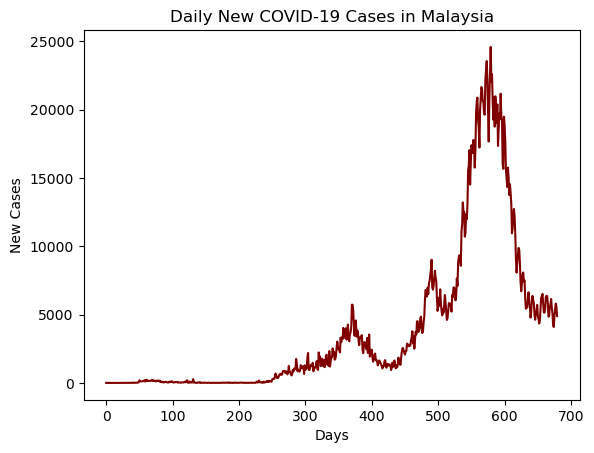

In [6]:
# Visual EDA: Daily New COVID-19 Cases in Malaysia (Train datasets)
plt.figure()
plt.plot(df["cases_new"], color='maroon')
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.title("Daily New COVID-19 Cases in Malaysia")
plt.savefig("pictures/Imran_new_cases_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [7]:
data = df["cases_new"].values  # To obtain data in ndarray format

In [8]:
mms = MinMaxScaler()
data = mms.fit_transform(np.expand_dims(data, axis=-1))

In [9]:
X_train, y_train = [], []  # Instatiate empty list

win_size = 30

for i in range(win_size, len(data)):
    X_train.append(data[i - win_size : i])
    y_train.append(data[i])

# Convert list into ndarray
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.3, random_state=123, shuffle=True
)

In [10]:
print(np.isnan(X_train).any())
print(np.isnan(y_train).any())

False
False


In [11]:
input_shape = np.shape(X_train)[1:]
model = Sequential()
model.add(LSTM(64, activation="relu", input_shape=input_shape, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, activation="relu", input_shape=input_shape, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation="linear"))
model.summary()
plot_model(model, show_shapes=True, to_file='pictures/Imran_model_architecture.png')

model.compile(optimizer="adam", loss="mse", metrics="mse")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [12]:
parent_folder = "tensorboard_log"
log_dir = os.path.join(
    os.getcwd(), parent_folder, datetime.datetime.now().strftime("%Y&m%d-%H%M%S")
)
tb_callback = TensorBoard(log_dir=log_dir)

# To include early stopping to prevent overfitting

es_callback = EarlyStopping(monitor="loss", patience=3)

hist = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[tb_callback],
)

Epoch 1/100
4/4 [==============================] - 8s 676ms/step - loss: 0.0704 - mse: 0.0704 - val_loss: 0.0525 - val_mse: 0.0525
Epoch 2/100
4/4 [==============================] - 2s 520ms/step - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 3/100
4/4 [==============================] - 2s 516ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 4/100
4/4 [==============================] - 2s 436ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 5/100
4/4 [==============================] - 2s 414ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 6/100
4/4 [==============================] - 2s 429ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 7/100
4/4 [==============================] - 2s 417ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 8/100
4/4 [==============================] - 2s 390ms/step - loss: 0.0106 - m

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


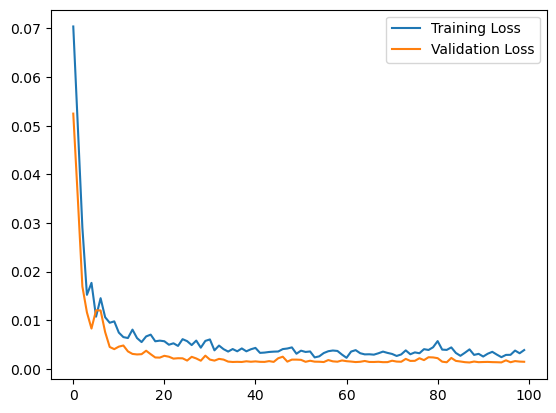

In [16]:
print(hist.history.keys())
plt.figure()
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.legend(["Training Loss", "Validation Loss"])
plt.savefig("pictures/Imran_trainval_loss_.png", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
df_test = pd.read_csv(os.path.join(os.getcwd(), "datasets", "cases_malaysia_test.csv"))
print(df_test.head())

df_test["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")
df_test["date"] = df_test["date"].dt.strftime("%Y-%m-%d")

        date  cases_new  cases_import  cases_recovered  cases_active  \
0  5/12/2021     4298.0            23             4928         61813   
1  6/12/2021     4262.0            15             5894         60139   
2  7/12/2021     4965.0            29             4817         60251   
3  8/12/2021     5020.0            17             4525         60709   
4  9/12/2021     5446.0            20             5427         60700   

   cases_cluster  cases_unvax  cases_pvax  cases_fvax  cases_boost  ...  \
0            136         1017          38        3093          150  ...   
1             97         1036          39        3056          131  ...   
2            138         1130          46        3642          147  ...   
3            154         1162          41        3674          143  ...   
4            367         1207          53        4034          152  ...   

   cases_60_69  cases_70_79  cases_80  cluster_import  cluster_religious  \
0          330          130        49   

In [18]:
print(df_test.head())

         date  cases_new  cases_import  cases_recovered  cases_active  \
0  2020-01-25     4298.0            23             4928         61813   
1  2020-01-26     4262.0            15             5894         60139   
2  2020-01-27     4965.0            29             4817         60251   
3  2020-01-28     5020.0            17             4525         60709   
4  2020-01-29     5446.0            20             5427         60700   

   cases_cluster  cases_unvax  cases_pvax  cases_fvax  cases_boost  ...  \
0            136         1017          38        3093          150  ...   
1             97         1036          39        3056          131  ...   
2            138         1130          46        3642          147  ...   
3            154         1162          41        3674          143  ...   
4            367         1207          53        4034          152  ...   

   cases_60_69  cases_70_79  cases_80  cluster_import  cluster_religious  \
0          330          130       

In [19]:
df_test["cases_new"] = pd.to_numeric(df_test["cases_new"], errors="coerce")
df_test["cases_new"] = df_test["cases_new"].interpolate(method="polynomial", order=2)

dataset_tot = pd.concat((df, df_test))
dataset_tot = dataset_tot["cases_new"].values

In [20]:
# MinMaxScaler for X
dataset_tot = mms.transform(np.expand_dims(dataset_tot, axis=-1))

X_actual, y_actual = [], []

for i in range(len(df), len(dataset_tot)):
    X_actual.append(dataset_tot[i - win_size : i])
    y_actual.append(dataset_tot[i])

X_actual = np.array(X_actual)
y_actual = np.array(y_actual)

y_pred_actual = model.predict(X_actual)

4/4 [==============================] - 1s 47ms/step


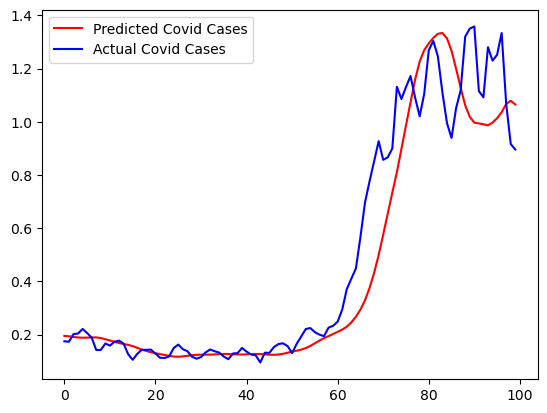

In [21]:
plt.figure()
plt.plot(y_pred_actual, color="red")
plt.plot(y_actual, color="blue")
plt.legend(["Predicted Covid Cases", "Actual Covid Cases"])
plt.savefig("pictures/Imran_predicted_vs_actual.png", dpi=300, bbox_inches="tight")
plt.show()

In [23]:
print(f'Mean Absolute Error(MSE): {mean_absolute_error(y_actual, y_pred_actual)}')
print(f'Mean Absolute Percentage Error(MAPE): {mean_absolute_percentage_error(y_actual, y_pred_actual)}')
print(f'r2 Score: {r2_score(y_actual, y_pred_actual)}')

Mean Absolute Error(MSE): 0.09272942021039764
Mean Absolute Percentage Error(MAPE): 0.1694797787293995
r2 Score: 0.8891667036726804


In [24]:
# create directory
dir_name = 'model_and_pickle'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

# save model
model.save(os.path.join(dir_name, 'model.h5'))

# save scaler object
with open(os.path.join(dir_name, 'mms.pkl'), 'wb') as f:
    pickle.dump(mms, f)